In [1]:
import sklearn
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs

In [2]:
input_file = codecs.open("D:\PythonProject\socialmedia_relevant_cols.csv", "r",encoding='utf-8', errors='replace')
output_file = open("D:\PythonProject\socialmedia_relevant_cols_clean.csv", "w",encoding='utf-8')

def sanitize_characters(raw, clean):    
    for line in input_file:
        out = line
        output_file.write(line)
sanitize_characters(input_file, output_file)

In [3]:
questions = pd.read_csv("D:\PythonProject\socialmedia_relevant_cols_clean.csv")
questions.columns=['text', 'choose_one', 'class_label']
questions.head()

,text,choose_one,class_label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


In [4]:
questions.tail()

,text,choose_one,class_label
10808,300K exotic car wrecked in train accident \r\r...,Relevant,1
10809,The twins pitcher's ego is now WRECKED,Not Relevant,0
10810,@Tunes_WGG lol. U got wrecked,Not Relevant,0
10811,you wrecked my whole world,Not Relevant,0
10812,I wrecked my stomach help,Not Relevant,0


In [5]:
questions.describe()

,class_label
count,10813.000000
mean,0.431610
std,0.498302
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


In [6]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    
    return df

questions = standardize_text(questions, "text")

questions.to_csv("D:\PythonProject\clean_data.csv")
questions.head()

,text,choose_one,class_label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this earthquake M...,Relevant,1
2,"Heard about earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask Canada,Relevant,1


In [7]:
clean_questions = pd.read_csv("D:\PythonProject\clean_data.csv")
clean_questions.tail()

,Unnamed: 0,text,choose_one,class_label
10808,10808,300K exotic car wrecked in train accident \n,Relevant,1
10809,10809,The twins pitcher's ego is now WRECKED,Not Relevant,0
10810,10810,lol U got wrecked,Not Relevant,0
10811,10811,you wrecked my whole world,Not Relevant,0
10812,10812,I wrecked my stomach help,Not Relevant,0


In [8]:
clean_questions.groupby("class_label").count()

,Unnamed: 0,text,choose_one
class_label,,,
0,6162,6162,6162
1,4635,4635,4635
2,16,16,16


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = clean_questions["text"].tolist()
list_labels = clean_questions["class_label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)
X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)
print(X_train_counts.shape)

(8650, 15943)


In [12]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [15]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

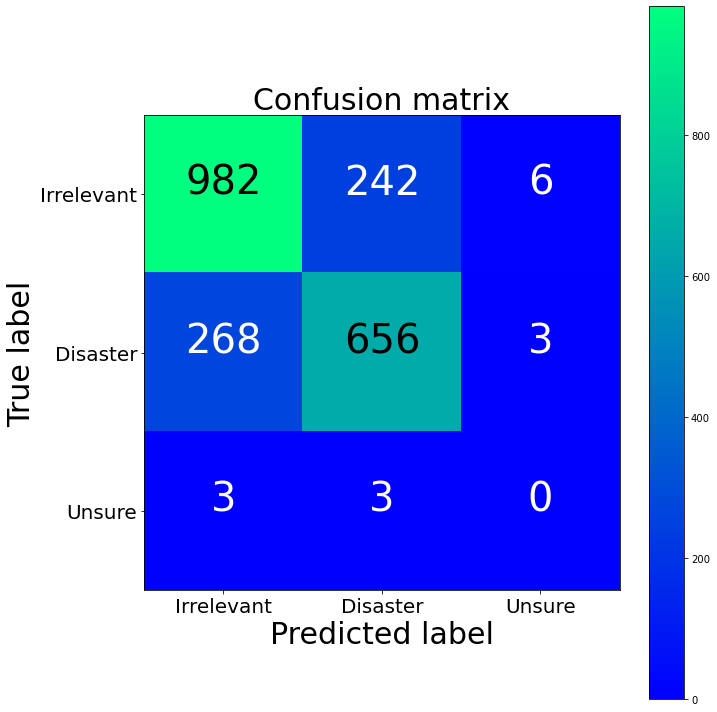

[[982 242   6]
 [268 656   3]
 [  3   3   0]]


In [16]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

### TFIDF

In [17]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [19]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)
train_mean = np.mean(y_predicted_tfidf, axis=0)
print(train_mean)
train_mean2 = np.std(y_predicted_tfidf, axis=0)
print(train_mean2)

0.4188626907073509
0.4961760394706411


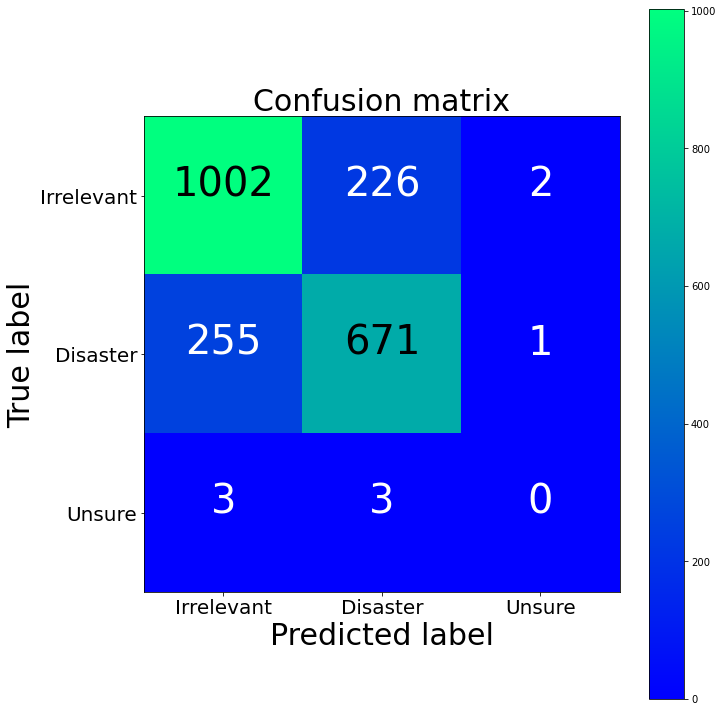

TFIDF confusion matrix
[[1002  226    2]
 [ 255  671    1]
 [   3    3    0]]


In [20]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)

# TF

In [21]:
tf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=False, smooth_idf=True, max_features=1000)
tf_train_model = tf_vectorizer.fit_transform(X_train)
tf_test_model = tf_vectorizer.fit_transform(X_test)


In [22]:
clf_tf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tf.fit(tf_train_model, y_train)

y_predicted_tf = clf_tf.predict(tf_test_model)
train_mean = np.mean(y_predicted_tf, axis=0)
print(train_mean)
train_mean2 = np.std(y_predicted_tf, axis=0)
print(train_mean2)

0.5460009246417014
0.5762172418056535


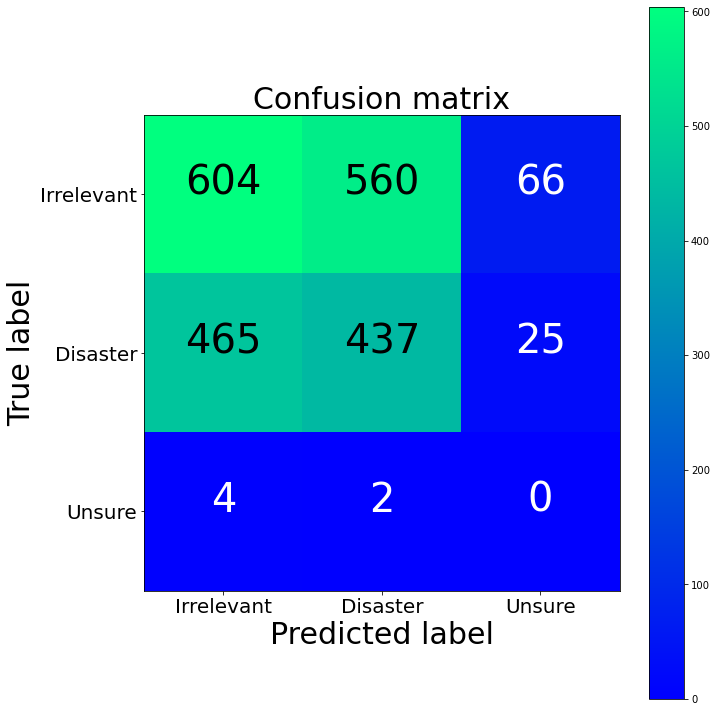

TF confusion matrix
[[604 560  66]
 [465 437  25]
 [  4   2   0]]


In [23]:
cm2 = confusion_matrix(y_test, y_predicted_tf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print("TF confusion matrix")
print(cm2)

# LSI

In [24]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

In [25]:
vectorizer = TfidfVectorizer(stop_words='english', 
                             use_idf=True, 
                             smooth_idf=True,max_features=1000)


In [26]:
lsa_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=10)
svd_transformer = Pipeline([('tfidf', vectorizer), 
                            ('svd', lsa_model)])

lsa_top = svd_transformer.fit_transform(X_train)

lsa_test = svd_transformer.transform(X_test)

In [27]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(lsa_top, y_train)

y_predicted_tfidf = clf_tfidf.predict(lsa_test)
train_mean = np.mean(y_predicted_tfidf, axis=0)
print(train_mean)
train_mean2 = np.std(y_predicted_tfidf, axis=0)
print(train_mean2)

0.7586685159500693
0.782383760234252


# Bert

In [28]:
import transformers
from transformers import BertTokenizer,TFBertModel
tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)
bert_model = transformers.TFBertModel.from_pretrained('bert-large-uncased')
def bert_encode(data,maximum_length) :
    input_ids = []
    attention_masks = []

    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
        
          data[i],
          add_special_tokens=True,
          max_length=maximum_length,
          pad_to_max_length=True,
        
          return_attention_mask=True,
        
        )
      
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

train_input_ids,train_attention_masks = bert_encode(X_train,1000)
test_input_ids,test_attention_masks = bert_encode(X_test,1000)

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length

In [29]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(train_input_ids, y_train)

y_predicted_tfidf = clf_tfidf.predict(test_input_ids)
train_mean = np.mean(y_predicted_tfidf, axis=0)
print(train_mean)
train_mean2 = np.std(y_predicted_tfidf, axis=0)
print(train_mean2)

0.643088303282478
0.6739537602013502
